# Optimizing MAX Phases with Featurization

Some design spaces cannot be reduced to simple, continuous representations that can be fed into Ax. For example, material compositions often span the periodic table and are subject to non-linear constraints like parsimony and electron counting rules that would be impossible to express in an Ax parameters object. One possible solution is to represent the composition as a one dimensional vector of the molar fractions of the materials' constituent elements. However, this representation assumes simple elemental substitution rules, which tyically only hold in limited composition ranges. Additionally, such a representation provides the model with little information about the unerlying physics and has been shown to be a weak predictor of material properties.

Featurization is the process of creating new representations that better describe the input data and are more ammendable to statistical modeling. In the context of material compositions, featurization typically involves creating a weighted combination of teh constituent elements' atomic properties. In this scheme, a material like Al2O3 is represented as a vector by averaging the properties of aluminum and oxygen, weighted by their molar fractions. In this tutorial, the popular featurization package,[`CBFV`](https://pypi.org/project/CBFV/), will be used to perform the featurization task.

---

MAX phase materials are a specialized group of compounds that blend the properties of metals and ceramics. MAX phase compositions are comprised of M, a transition metal; A, a group 13 or 14 element; and X, carbon or nitrogen. MAX phases are of particular interest in high temperature, structural applications. 

You have been tasked with finding a new MAX phase composition with a high elastic modulus to be used as a cladding material in a next generation nuclear reactor. A colleague in your lab spent a few weeks looking through the literature and has identified a set of reported MAX phase materials that haven't been tested for modulus, but look promising.

You believe Bayesian optimization can help faciliate this search, and decide to use Honegumi to help construct an optimization script.

To simulate this task, a helper function is provided that automatically pulls and splits the data in a representative way. An explanation of this function is provided in subsequent cells and in line comments. Although optimal values could easily be found using the tabulated data, we will pretend that such data is unknown and use Bayesian optimization to find the optimal material instead.

In [36]:
import matplotlib.pyplot as plt
from CBFV import composition
from matminer.datasets import load_dataset

def generate_data(seed=42):
    """
    Constructs training and cadidate data from a benchmark MAX phase dataset by sampling
    8 points with elastic modulus <= 200 GPa for training and using the remaining data
    as candidates for optimization.

    Args:
        seed (int): Random seed for reproducibility. Default is 42.

    Returns:
        tuple: A tuple containing two DataFrames:
            - `train`: A DataFrame of 8 sampled points with elastic modulus <= 200 GPa.
            - `candidate`: A DataFrame of the remaining data after sampling.
    """
    # load benchmark dataset, pull the formula and elastic modulus
    data = load_dataset("m2ax", pbar=True)[['formula', 'elastic modulus']]
    data.rename(columns={'elastic modulus': 'target'}, inplace=True)

    # generate an initial data by sampling 8 points with elastic modulus <= 200 GPa
    train = data[data.target <= 200].sample(n=8, random_state=seed)
    candidates = data.drop(train.index)

    return train, candidates

## Featurizing Compositions

In the code cell below, we will featurize the training and candidate materials using the `CBFV` packages. In the interest of keeping the tutorial simple, we will subsample the generated features, keeping every 20th feature.

In [37]:
# create training and candidate datasets
train, candidates = generate_data()

# show the first five compositions in the training set
display(train.head())

# featurize the compositions, keep every 20th feature for tutorial simplicity
X_train, y_train, formula, _ = composition.generate_features(train)
X_train = X_train.iloc[:, ::20]

X_candidates, y_candidates, _, _ = composition.generate_features(candidates)
X_candidates = X_candidates.iloc[:, ::20]

Reading file /Users/andrewf/miniconda3/envs/ax_env_pip/lib/python3.10/site-packages/matminer/datasets/m2ax.json.gz: 0it [00:00, ?it/s]0, ?it/s]
Decoding objects from /Users/andrewf/miniconda3/envs/ax_env_pip/lib/python3.10/site-packages/matminer/datasets/m2ax.json.gz: 0it [00:00, ?it/s]


,formula,target
89,Cr2SnN,141
45,Ti2TlN,200
111,Mo2PbN,138
174,Hf2CdC,174
0,Sc2AlC,140


Processing Input Data: 100%|██████████| 8/8 [00:00<00:00, 4279.90it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 8/8 [00:00<00:00, 9592.46it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 215/215 [00:00<00:00, 42091.83it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 215/215 [00:00<00:00, 12453.57it/s]

	Creating Pandas Objects...


## Applying Honegumi

We will now use the [Honegumi](https://honegumi.readthedocs.io/en/latest/index.html) website to generate a script that will help us optimize our material composition for elastic modulus. Unlike other tutorials, however, this will require more extensive modifications to the generated script in order to facilitate feeding in predefined candidate solutions. From the description, we observe that our problem is a **single objective** optimization problem with some **existing materials data**. Additionally, as our problem doesn't have a simple continuous representation, typical Sobol generation won't work, so we will want to adjust the generation strategy somewhat, which can be exposed by selecting the **Fully Bayesian** option.

![Featurization Selection](featurization_selection.png)

The Honegumi generated optimization script will provide a framework for our optimization campaign that we can modify to suit our specific problem needs. In the code sections below, we will make several modifications to this generated script to make it compatible with our problem.

## Modifying the Code for Our Problem
We can modify this code to suit our problem with a few simple modifications. Wherever a modification has been made to the code, a comment starting with `# CHANGE:` has been added along with a brief description of the change.

In [38]:
import numpy as np
from ax.service.ax_client import AxClient, ObjectiveProperties

from ax.modelbridge.factory import Models
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy

import pandas as pd

obj1_name = "elastic_modulus"  # CHANGE: update objective name

# CHANGE: remove the branin dummy objective function, we will use tabulated data

# CHANGE: remove dummy training data, we defined this in an earlier cell

n_train = len(X_train)

gs = GenerationStrategy(
    steps=[
        # CHANGE: remove sobol sampling step
        GenerationStep(
            model=Models.BOTORCH_MODULAR,  # CHANGE: use modular botorch model
            num_trials=-1,
            max_parallelism=3,
            model_kwargs={},
        ),
    ]
)

ax_client = AxClient(generation_strategy=gs)

ax_client.create_experiment(
    parameters=[ # CHANGE: create flexible parameters for all generated features
        {"name": feat, "type": "range", "bounds": [-1e5, 1e5]}
        for feat in X_train.columns
    ],
    objectives={
        obj1_name: ObjectiveProperties(minimize=False)  # CHANGE: maximize the objective
    },
)

# Add existing data to the AxClient
for i in range(n_train):
    parameterization = X_train.iloc[i].to_dict()

    ax_client.attach_trial(parameterization)
    ax_client.complete_trial(trial_index=i, raw_data=y_train.iloc[i])  # CHANGE: iloc

from ax.core.observation import ObservationFeatures # CHANGE: import ObservationFeatures

selected_indices = []  # CHANGE: create list to store selected indices
for i in range(n_train, n_train + 19): # CHANGE: account for training data in trial num

    ax_client.fit_model()  # CHANGE: fit the model to the known data
    model = ax_client.generation_strategy.model  # CHANGE: get model object as var

    # CHANGE: define candidates as ObservationFeatures before passing to model
    obs_feat = [
        ObservationFeatures(
            {col: val for col, val in zip(X_candidates.columns, X_candidates.iloc[i])}
        )
        for i in range(len(X_candidates))
    ]

    # CHANGE: evaluate the acquisition function on each candidate, and pull the best
    acqf_values = np.array(
        model.evaluate_acquisition_function(observation_features=obs_feat)
    )
    acqf_values[selected_indices] = -100  # give prev selected points a low value

    best_index = np.argmax(acqf_values) # get the index of the best candidate
    selected_indices.append(best_index) # append this to the selected indices list

    results = y_candidates.iloc[best_index]  # CHANGE: "measure" the best idx candidate

    ax_client.attach_trial(X_candidates.iloc[best_index].to_dict())
    ax_client.complete_trial(trial_index=i, raw_data=results)

[INFO 08-08 15:35:14] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 08-08 15:35:14] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter avg_Atomic_Number. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 08-08 15:35:14] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter avg_Allred-Rockow_electronegativity. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 08-08 15:35:14] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter avg_heat_of_vaporization_(kJ/mol)_. If that is not the expected value type, you can explicitly specify 'value_type' ('int'

## Show the Best Material

After our optimization loop has completed, we can look through the data to find the best discovered material.

In [26]:
best_trial_index = ax_client.get_trials_data_frame()[obj1_name].idxmax()

print("\nBest Material: ", formula[best_indices[best_trial_index]])

[WARNING 08-06 18:39:07] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.



Best Material:  Hf2AlN


## Plotting Optimization Performance

We can plot the performance of our optmization loop to see how the optimization task progressed as a function of iteration count.

[WARNING 08-08 15:37:56] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


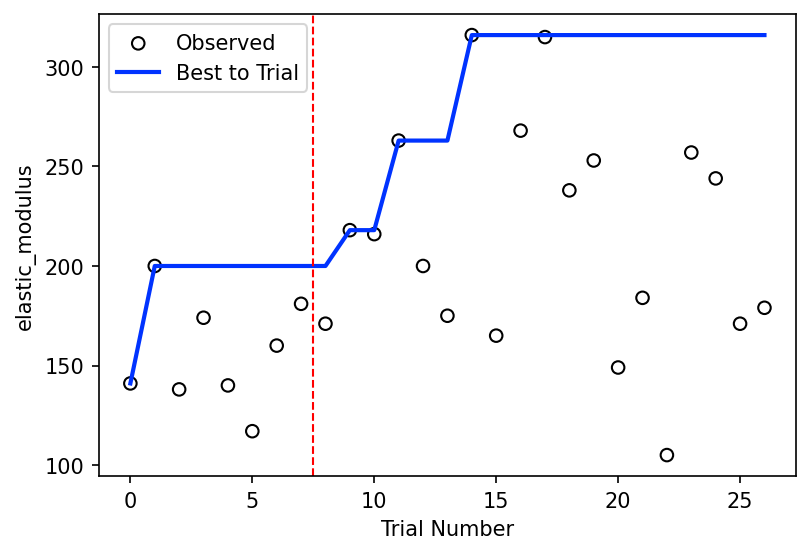

In [41]:
objectives = ax_client.objective_names
df = ax_client.get_trials_data_frame()[objectives]

best_to_trial = np.maximum.accumulate(df) # change if maximizing

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.scatter(df.index, df, ec="k", fc="none", label="Observed")
ax.plot(best_to_trial, color="#0033FF", lw=2, label="Best to Trial")

ax.axvline(7.5, color="r", ls="--", lw=1)

ax.set_xlabel("Trial Number")
ax.set_ylabel(objectives[0])
ax.legend()
plt.show()